# Finding a Circuit

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
sys.path.append("/workspace/circuit-finder")

In [11]:
from circuit_finder.pretrained import load_model, load_attn_saes, load_hooked_mlp_transcoders
from circuit_finder.patching.indirect_leap import preprocess_attn_saes, LEAPConfig, IndirectLEAP
from circuit_finder.experiments.run_leap_experiment import ProjectDir, run_leap, datasets, compute_logit_diff, get_clean_and_corrupt_metric, EAPGraph

model = load_model()
attn_saes = load_attn_saes()
attn_saes = preprocess_attn_saes(attn_saes, model)
hooked_mlp_transcoders = load_hooked_mlp_transcoders()
metric_fn_name = "logit_diff"
cfg = LEAPConfig(
    threshold=0.001,
    contrast_pairs=True,
    qk_enabled=True,
    chained_attribs=True,
    allow_neg_feature_acts=False,
    store_error_attribs=True,
)

example = datasets['gender-bias']
# Setup the tokens
clean_tokens = example.clean_tokens(model)
answer_tokens = example.answer_tokens(model)
wrong_answer_tokens = example.wrong_answer_tokens(model)
corrupt_tokens = example.corrupt_tokens(model)

# Setup the metric function
if metric_fn_name == "logit_diff":

    def metric_fn(model, tokens):
        logit_diff = compute_logit_diff(
            model, tokens, answer_tokens, wrong_answer_tokens
        )
        return logit_diff.mean()
else:
    raise ValueError(f"Unknown metric_fn_name: {metric_fn_name}")

clean_metric, corrupt_metric = get_clean_and_corrupt_metric(
    model, metric_fn, clean_tokens, corrupt_tokens
)

# Run LEAP
leap = IndirectLEAP(
    cfg=cfg,
    tokens=clean_tokens,
    model=model,
    metric=metric_fn,
    attn_saes=attn_saes,  # type: ignore
    transcoders=hooked_mlp_transcoders,
    corrupt_tokens=corrupt_tokens,
)
leap.run()
graph = EAPGraph(leap.graph)
error_graph = EAPGraph(leap.error_graph)


print(f"Clean Metric: {leap_experiment_result.clean_metric}")
print(f"Corrupt Metric: {leap_experiment_result.corrupt_metric}")

/workspace/circuit-finder/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

Clean Metric: 0.7484140396118164
Corrupt Metric: -3.045534133911133


In [5]:
clean_metric = leap_experiment_result.clean_metric
corrupt_metric = leap_experiment_result.corrupt_metric
graph = leap_experiment_result.graph

In [6]:
from circuit_finder.plotting import make_html_graph

print(len(graph.get_edges()))
make_html_graph(leap)


748


NameError: name 'leap' is not defined

In [ ]:
if 'leap' in globals():
    del leap
clear_memory()

In [9]:
# Convert the graph to a dataframe

import pandas as pd 
from circuit_finder.core.types import parse_node_name

rows = []
for edge, edge_info, edge_type in graph.graph:
    (dest, src) = edge
    if dest == "null": continue
    (node_node_attr, node_node_grad, edge_metric_attr, edge_metric_grad) = edge_info

    src_module_name, src_layer, src_token_idx, src_feature_idx = parse_node_name(src)    
    dest_module_name, dest_layer, dest_token_idx, dest_feature_idx = parse_node_name(dest)

    rows.append({
        "src_module_name": src_module_name,
        "src_layer": src_layer,
        "src_token_idx": src_token_idx,
        "src_feature_idx": src_feature_idx,
        "dest_module_name": dest_module_name,
        "dest_layer": dest_layer,
        "dest_token_idx": dest_token_idx,
        "dest_feature_idx": dest_feature_idx,
        "edge_metric_attr": edge_metric_attr,
        "edge_metric_grad": edge_metric_grad,
        "node_node_attr": node_node_attr,
        "node_node_grad": node_node_grad,
        "edge_type": edge_type
    }) 

df = pd.DataFrame(rows)
print(len(df))
df.head()

738


,src_module_name,src_layer,src_token_idx,src_feature_idx,dest_module_name,dest_layer,dest_token_idx,dest_feature_idx,edge_metric_attr,edge_metric_grad,node_node_attr,node_node_grad,edge_type
0,mlp,0,9,4863,metric,12,9,0,0.021989,0.003526,0.021989,0.003526,None
1,mlp,0,9,11891,metric,12,9,0,0.009094,0.002660,0.009094,0.002660,None
2,mlp,0,9,20543,metric,12,9,0,0.022519,0.001831,0.022519,0.001831,None
3,mlp,0,9,23862,metric,12,9,0,0.025424,0.004463,0.025424,0.004463,None
4,mlp,2,9,2447,metric,12,9,0,0.006739,0.012855,0.006739,0.012855,None


## Node Attribution 



In [10]:
import torch

from circuit_finder.patching.ablate import splice_model_with_saes_and_transcoders
from circuit_finder.patching.gradient_cache import get_gradient_cache

with splice_model_with_saes_and_transcoders(model, transcoders, attn_saes) as spliced_model:
    grad_cache = get_gradient_cache(spliced_model, clean_tokens, metric_fn)

    with torch.no_grad():
        _, clean_cache = model.run_with_cache(clean_tokens)
        _, corrupt_cache = model.run_with_cache(corrupt_tokens)


NameError: name 'transcoders' is not defined

In [ ]:
# Compute node attributions
attr_cache = {}
for node, grad in grad_cache.items():
    # NOTE on sign: 
    # clean - corr --> positive attrib means metric(clean) is higher than metric(corr). 
    attr_cache[node] = grad * (clean_cache[node] - corrupt_cache[node])

In [ ]:
# Get the features with high attribution 

import pandas as pd

attn_act_names = [
    f"blocks.{layer}.attn.hook_z.hook_sae_acts_post" for layer in range(model.cfg.n_layers)
]

transcoder_act_names = [
    f"blocks.{layer}.mlp.transcoder.hook_sae_acts_post" for layer in range(model.cfg.n_layers)
]

all_act_names = attn_act_names + transcoder_act_names


def get_node_attrib_df():
    dfs = []
    for act_name in all_act_names:
        node_attrib = attr_cache[act_name]
        feature_idx = list(range(node_attrib.shape[-1]))
        total_node_attrib = node_attrib.sum(0).sum(0).tolist()
        
        df = pd.DataFrame({
            "feature_idx": feature_idx,
            "total_node_attrib": total_node_attrib,
        })
        df['act_name'] = act_name
        df['layer'] = int(act_name.split('.')[1])
        df['module_name'] = act_name.split('.')[2]
        dfs.append(df)

    df = pd.concat(dfs)
    print(len(df))
    df.head()

node_attrib_df = get_node_attrib_df()


884736


# Micro Analysis

In [ ]:
def get_outgoing_edge_df(
    df: pd.DataFrame, 
    src_module_name: str,
    src_layer: int,
    src_feature_idx: int,
):
    return df[
        (df["src_module_name"] == src_module_name)
        & (df["src_layer"] == src_layer)
        & (df["src_feature_idx"] == src_feature_idx)
    ]

def get_incoming_edge_df(
    df: pd.DataFrame, 
    dest_module_name: str,
    dest_layer: int,
    dest_feature_idx: int,
):
    return df[
        (df["dest_module_name"] == dest_module_name)
        & (df["dest_layer"] == dest_layer)
        & (df["dest_feature_idx"] == dest_feature_idx)
    ]

In [ ]:
# Define some utilities for patching a single node

from transformer_lens import ActivationCache
from circuit_finder.core.types import Node, parse_node_name

def get_act_name(module_name, layer):
    if module_name == "attn":
        return f"blocks.{layer}.attn.hook_z.hook_sae_acts_post"
    elif module_name == "mlp":
        return f"blocks.{layer}.mlp.transcoder.hook_sae_acts_post"
    elif module_name == "mlp_error":
        raise NotImplemetedError
    elif module_name == "attn_error":
        raise NotImplementedError
    else:
        raise ValueError(module_name)

def get_node_act(
    cache: ActivationCache,
    module_name, layer, token_idx, feature_idx
):
    act_name = get_act_name(module_name, layer)
    return cache[act_name][:, token_idx, feature_idx]

def node_patch_hook(act, hook, token_idx, feature_idx, value):
    """ Patches a node by setting its activation to a fixed value. """
    act[:, token_idx, feature_idx] = value
    return act

def get_node_patch_hook(
    node: Node,
    value: float
):

    module_name, layer, token_idx, feature_idx = parse_node_name(node)
    hook_name = get_act_name(module_name, layer)

    def hook_fn(act, hook):
        return node_patch_hook(act, hook, token_idx, feature_idx, value)
    
    return hook_name, hook_fn


In [ ]:
# Get the clean and corrupt cache
from circuit_finder.patching.ablate import splice_model_with_saes_and_transcoders

def filter_sae_acts_and_errors(name: str):
    return "hook_sae_acts_post" in name or "hook_sae_error" in name

with splice_model_with_saes_and_transcoders(model, transcoders, attn_saes) as spliced_model:
    _, clean_cache = model.run_with_cache(clean_tokens, names_filter = filter_sae_acts_and_errors)
    _, corrupt_cache = model.run_with_cache(corrupt_tokens, names_filter = filter_sae_acts_and_errors)



In [ ]:
from circuit_finder.core.types import get_node_name, parse_node_name

nodes = {
    "doctor_detector": get_node_name("mlp", 1, 2, 10644),
}

### Doctor Detector

Look at the outgoing edges

In [ ]:
module_name, layer, token_idx, feature_idx = parse_node_name(nodes["doctor_detector"])
get_outgoing_edge_df(df, module_name, layer, feature_idx).sort_values('edge_metric_attr', ascending = False)

,src_module_name,src_layer,src_token_idx,src_feature_idx,dest_module_name,dest_layer,dest_token_idx,dest_feature_idx,edge_metric_attr,edge_metric_grad,node_node_attr,node_node_grad,edge_type
255,mlp,1,2,10644,mlp,7,2,22510,0.001120,0.009598,0.067385,0.577718,None
287,mlp,1,2,10644,mlp,6,2,13188,0.000958,0.008213,0.095022,0.814664,None
331,mlp,1,2,10644,mlp,3,2,19883,0.000869,0.007447,0.115886,0.993541,None
238,mlp,1,2,10644,mlp,7,2,7611,0.000847,0.007260,0.042722,0.366278,None
302,mlp,1,2,10644,mlp,5,2,5922,0.000664,0.005693,0.090604,0.776792,None
312,mlp,1,2,10644,mlp,5,2,17446,0.000597,0.005118,0.054334,0.465831,None
282,mlp,1,2,10644,mlp,6,2,15503,0.000467,0.004005,0.061043,0.523349,None
147,mlp,1,2,10644,attn,10,9,19969,0.000423,0.003630,0.000975,0.008358,ov
219,mlp,1,2,10644,attn,8,9,18618,0.000409,0.003509,0.001487,0.012747,ov
227,mlp,1,2,10644,attn,8,9,919,0.000403,0.003452,0.005066,0.043435,ov


Plot causal ablation graph

In [ ]:
with torch.no_grad():
    clean_metric = metric_fn(model, clean_tokens).item()
    corrupt_metric = metric_fn(model, corrupt_tokens).item()
clean_act = get_node_act(clean_cache, module_name, layer, token_idx, feature_idx).item()
corrupt_act = get_node_act(corrupt_cache, module_name, layer, token_idx, feature_idx).item()

print("Clean metric: ", clean_metric)
print("Corrupt metric: ", corrupt_metric)
print("Clean activation: ", clean_act)
print("Corrupt activation: ", corrupt_act)

Clean metric:  0.7484140396118164
Corrupt metric:  -3.045534133911133
Clean activation:  10.073238372802734
Corrupt activation:  1.499787449836731


In [ ]:
# Node patching for L8.Att.14.16513

values = []
metrics = []
with splice_model_with_saes_and_transcoders(model, transcoders, attn_saes) as spliced_model:
    for value in range(40):
        with model.hooks(fwd_hooks = [get_node_patch_hook(nodes["doctor_detector"], value)]):
            metric = metric_fn(model, clean_tokens).item()
            metrics.append(metric)
            values.append(value)

Text(0, 0.5, 'Metric')

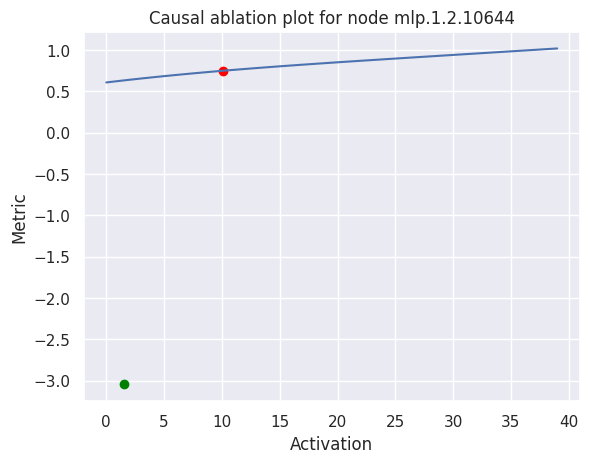

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt

sns.set_theme()
sns.lineplot(x = values, y = metrics)
plt.scatter([clean_act], [clean_metric], color = 'red')
plt.scatter([corrupt_act], [corrupt_metric], color = 'green')
# plt.axvline(x = clean_act, color = 'red')
# plt.axvline(x = corrupt_act, color = 'green')

plt.title(f"Causal ablation plot for node {nodes['doctor_detector']}")
plt.xlabel("Activation")
plt.ylabel("Metric")


Plot cosine similarity to MLP weights

In [ ]:
from einops import repeat
import torch.nn.functional as F

# Get the relevant weights
W_dec = transcoders[1].W_dec
mlp_W_out = model.blocks[1].mlp.W_out
w_dec = W_dec[10644]
w_dec_repeat = repeat(w_dec, 'f -> b f', b = mlp_W_out.shape[0])
print(w_dec_repeat.shape)
print(mlp_W_out.shape)
# Compute cosine similarity

cosine_sim = F.cosine_similarity(w_dec, mlp_W_out, dim=-1)
print(cosine_sim.shape)
cosine_sim_np = cosine_sim.detach().cpu().numpy()



torch.Size([3072, 768])
torch.Size([3072, 768])
torch.Size([3072])


Text(0.5, 1.0, 'Cosine similarity between doctor detector W_dec and Layer 1 MLP W_out')

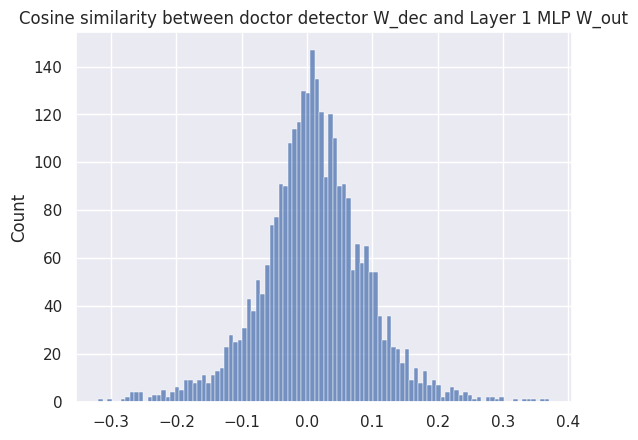

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt 

sns.set_theme()
sns.histplot(cosine_sim_np, bins=100)
plt.title("Cosine similarity between doctor detector W_dec and Layer 1 MLP W_out")


### "Him" Predictor


## Causal Ablation Plot for Whole Circuit

Intervene on multiple nodes, linearly interpolating between the clean and corrupt activations.


In [ ]:
from functools import partial

def get_circuit_node_patch_hooks(
    clean_cache: ActivationCache, 
    corrupt_cache: ActivationCache,
    nodes: list[Node],
    coefficient: float,
):  
    """ Return a list of patch hooks """

    fwd_hooks = []
    for node in nodes:
        module_name, layer, token_idx, feature_idx = parse_node_name(node)
        hook_name = get_act_name(module_name, layer)
        clean_value = get_node_act(clean_cache, module_name, layer, token_idx, feature_idx)
        corrupt_value = get_node_act(corrupt_cache, module_name, layer, token_idx, feature_idx)
        # Interpolate to get the value
        # c = 0 --> corrupt value
        # c = 1 --> clean value
        value = (clean_value - corrupt_value) * coefficient + corrupt_value
        hook_fn = partial(node_patch_hook, token_idx = token_idx, feature_idx = feature_idx, value = value)
        fwd_hooks.append((hook_name, hook_fn))
    return fwd_hooks


In [ ]:
all_nodes = graph.get_src_nodes()
all_nodes = [n for n in all_nodes if "metric" not in n]
print(len(all_nodes))
print(all_nodes)


193
['attn.0.2.5645', 'attn.0.2.8302', 'attn.0.2.8342', 'attn.1.2.22089', 'attn.1.2.6942', 'attn.1.9.22089', 'attn.1.9.5167', 'attn.10.9.14709', 'attn.10.9.19969', 'attn.10.9.9826', 'attn.11.9.16249', 'attn.2.2.5981', 'attn.2.3.16190', 'attn.2.3.5993', 'attn.2.9.1690', 'attn.2.9.64', 'attn.3.9.6243', 'attn.4.3.18201', 'attn.4.9.14699', 'attn.5.9.21023', 'attn.6.3.24311', 'attn.6.9.10395', 'attn.6.9.11999', 'attn.6.9.21937', 'attn.6.9.4261', 'attn.7.9.18701', 'attn.8.3.9836', 'attn.8.9.12644', 'attn.8.9.18618', 'attn.8.9.19019', 'attn.8.9.2187', 'attn.8.9.2890', 'attn.8.9.3113', 'attn.8.9.6148', 'attn.8.9.919', 'attn.9.3.10956', 'attn.9.5.9938', 'attn.9.9.10823', 'attn.9.9.10956', 'attn.9.9.11453', 'attn.9.9.15766', 'attn.9.9.19558', 'attn.9.9.21444', 'attn.9.9.22459', 'attn.9.9.3211', 'attn.9.9.3229', 'attn.9.9.4014', 'mlp.0.2.11331', 'mlp.0.2.14981', 'mlp.0.2.24188', 'mlp.0.2.2638', 'mlp.0.2.9124', 'mlp.0.3.14777', 'mlp.0.9.11891', 'mlp.0.9.20543', 'mlp.0.9.23862', 'mlp.0.9.4863', 'ml

In [ ]:
results = {}

In [ ]:
# Noising setting
import numpy as np

coefficients = []
metrics = []
with splice_model_with_saes_and_transcoders(model, transcoders, attn_saes) as spliced_model:
    for coefficient in np.linspace(0, 1, 11):
        fwd_hooks = get_circuit_node_patch_hooks(
            clean_cache, 
            corrupt_cache,
            all_nodes,
            coefficient
        )
        with model.hooks(fwd_hooks = fwd_hooks):
            metric = metric_fn(model, clean_tokens).item()
            metrics.append(metric)
            coefficients.append(coefficient)

results['noising'] = {
    'coefficients': coefficients,
    'metrics': metrics
}

In [ ]:
# Denoising setting
coefficients = []
metrics = []
with splice_model_with_saes_and_transcoders(
    model, transcoders, attn_saes
) as spliced_model:
    for coefficient in np.linspace(0, 1, 11):
        # NOTE: In the noising setting, the clean and corrupt caches are swapped
        fwd_hooks = get_circuit_node_patch_hooks(
            corrupt_cache, clean_cache, all_nodes, coefficient
        )
        with model.hooks(fwd_hooks=fwd_hooks):
            # NOTE: In the noising setting, the clean and corrupt tokens are swapped
            metric = metric_fn(model, corrupt_tokens).item()
            metrics.append(metric)
            # NOTE: in the noising setting, the role of the coefficient is inverted
            coefficients.append(1 - coefficient)

results['denoising'] = {
    'coefficients': coefficients,
    'metrics': metrics
}

Text(0, 0.5, 'Metric')

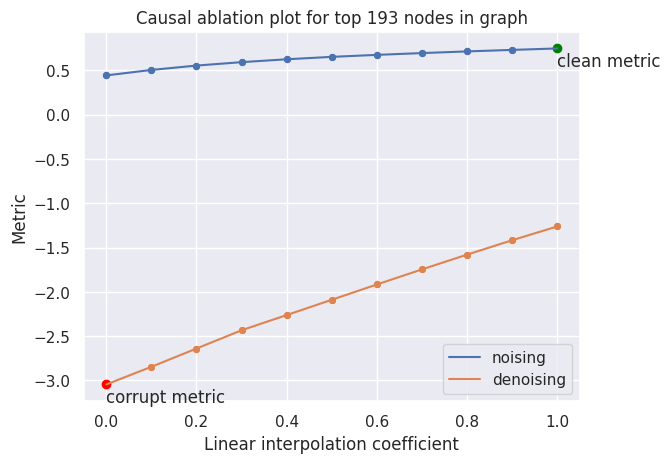

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
for setting, result in results.items():
    coefficients = result["coefficients"]
    metrics = result["metrics"]
    sns.lineplot(x=coefficients, y=metrics, label=setting)
    sns.scatterplot(x=coefficients, y=metrics)
plt.legend()
# Add text
text_offset = -0.2
plt.scatter([1], [clean_metric], color="green")
plt.text(1, clean_metric + text_offset, "clean metric", fontsize=12)
plt.scatter([0], [corrupt_metric], color="red")
plt.text(0, corrupt_metric + text_offset, "corrupt metric", fontsize=12)

plt.title(f"Causal ablation plot for top {len(all_nodes)} nodes in graph")
plt.xlabel("Linear interpolation coefficient")
plt.ylabel("Metric")

In [ ]:
print(attn_saes[0].W_dec.shape)

torch.Size([49152, 768])


In [ ]:
# TODO: Repeat this for many values of the top K nodes
# TODO: Repeat this for a few other ciruits